In [1]:
!pip install geopandas
!pip install rioxarray

import numpy as np
import matplotlib.pyplot as plt
from math import *
import cv2
import geopandas as gpd
from google.colab import drive
import os
import pickle
import rioxarray
from pyproj import CRS
import fiona
from scipy.stats.stats import pearsonr
from matplotlib.collections import PatchCollection
import matplotlib
from sklearn.metrics import r2_score

drive.mount("/content/drive")
os.chdir('/content/drive/MyDrive/DREAMS - Zhiang/Projects/Rock Traits/data')
print(os.listdir())

     |████████████████████████████████| 1.0 MB 5.5 MB/s 
     |████████████████████████████████| 15.4 MB 32.8 MB/s 
     |████████████████████████████████| 6.3 MB 59.3 MB/s 
     |████████████████████████████████| 46 kB 2.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 19.3 MB 1.2 MB/s 
  Created wheel for rioxarray: filename=rioxarray-0.9.0-py3-none-any.whl size=54395 sha256=d2d8b7e70fd0ba22c4a424ab5fb0d7b62d4480872a7e2e897e4d8cbdfa0a9201
  Stored in directory: /root/.cache/pip/wheels/f2/0d/f2/29da7ed804b71eb1317c3683b373f59d7c0c4c501117f2b144
Successfully built rioxarray
Mounted at /content/drive
['README', 'C3_sk.jpg', 'registered_instances_c3_rgbd1.pickle', 'registered_instances_c3_rgbd1_refined.pickle', 'registered_instances_c3_rgbd1_refined_update.pickle', 'C3.tif', 'c3_rocks', 'registered_instances_c3_rgbd1_update.pickle', 'registered_instances_c3_rgbd1_u

In [53]:
profile_list = []

for idx in range(16,0,-1):
  f = 'profile_data/PG{idx}.shp'.format(idx=idx)
  profile_shp = gpd.read_file(f)
  x = np.asarray(profile_shp.geometry.x)
  y = np.asarray(profile_shp.geometry.y)
  z = np.asarray(profile_shp.geometry.z)
  xyz = np.vstack((x, y, z)).transpose()
  profile_list.append(xyz)

In [123]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams.update({'font.size': 15})

def convert_profile(profile_ndarray):
  xyz = profile_ndarray - profile_ndarray[0]
  dist = np.sqrt(xyz[:, 0]**2 + xyz[:, 1]**2)
  x = np.arange(0, dist[-1], 0.1)
  y = np.interp(x, dist, xyz[:, 2])
  return np.vstack((x,y)).transpose()

def display_profile(converted_profile_ndarray, ticks=False):
  plt.plot(converted_profile_ndarray[:, 0], converted_profile_ndarray[:, 1])
  plt.xlabel('cross scarp distance')
  plt.ylabel('height')
  plt.xlim(0, 88)
  plt.ylim(-21, 1)
  if ticks:
    plt.xticks(np.arange(0,88,5))
    plt.grid()
  plt.show()

def crop_profile(profile_ndarray):
  display_profile(profile_ndarray, ticks=True)
  x = input('Input distance: ')
  cropped_profile = profile_ndarray[profile_ndarray[:, 0]>float(x)]
  display_profile(cropped_profile)
  return cropped_profile


In [116]:
converted_profile_ndarray = []
for i in range(16):
  converted_profile = convert_profile(profile_list[i])
  #display_profile(converted_profile)
  converted_profile_ndarray.append(converted_profile)

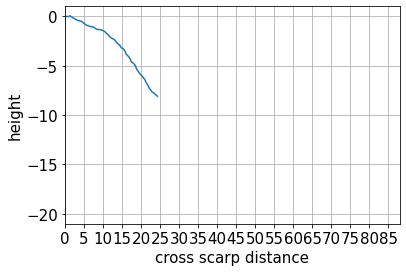

Input distance: 0


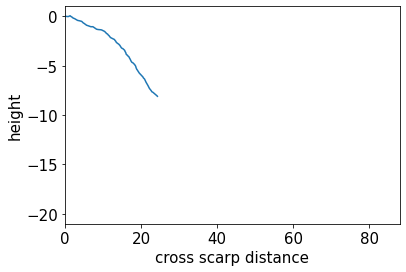

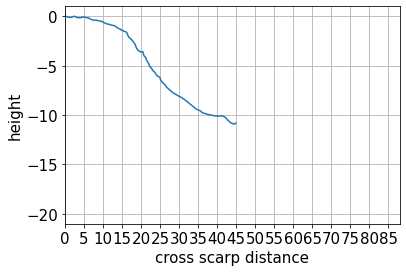

Input distance: 15


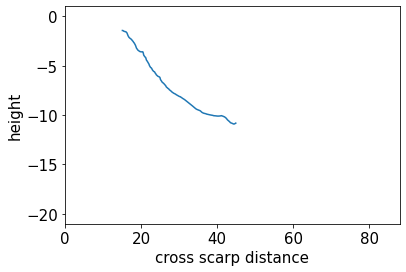

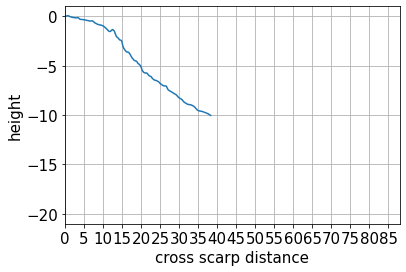

Input distance: 12.5


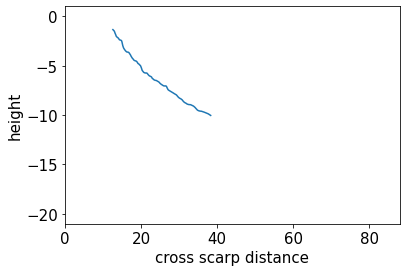

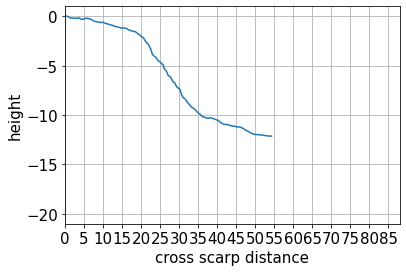

Input distance: 19


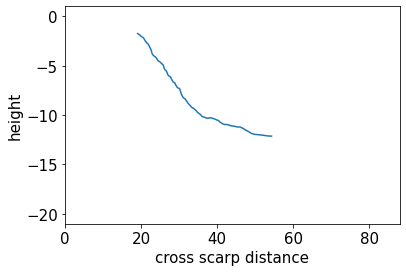

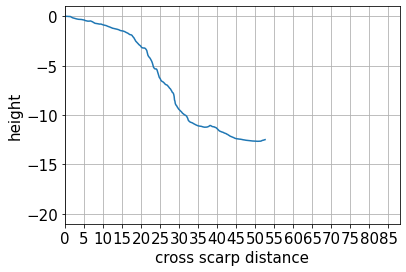

Input distance: 17


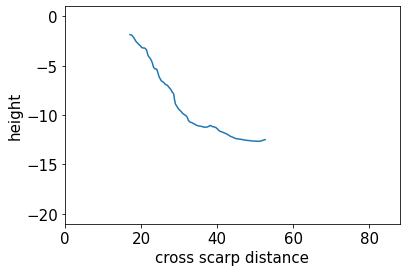

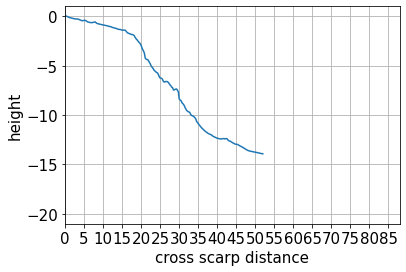

Input distance: 18


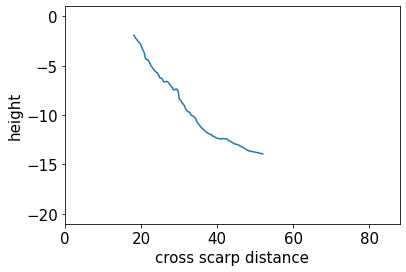

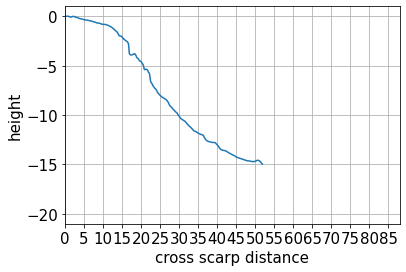

Input distance: 12.5


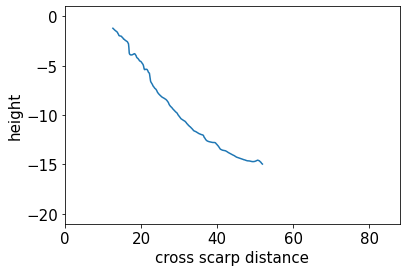

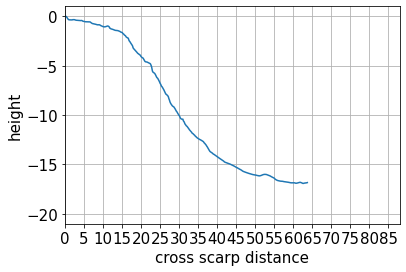

Input distance: 15


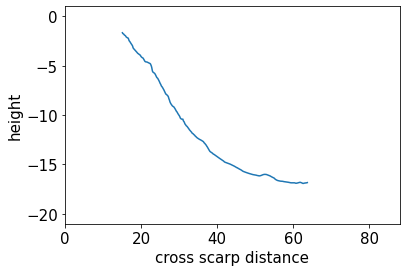

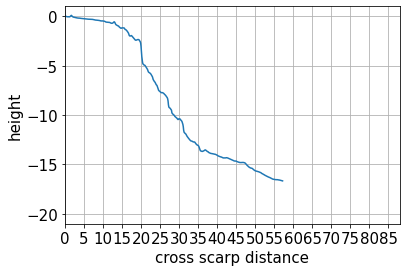

Input distance: 19


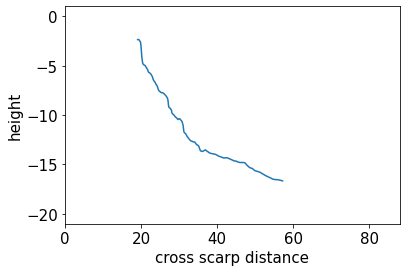

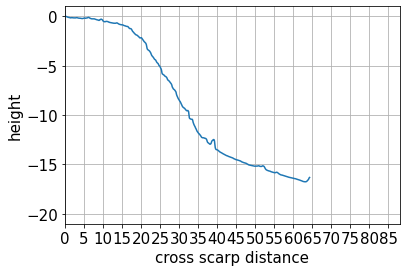

Input distance: 17


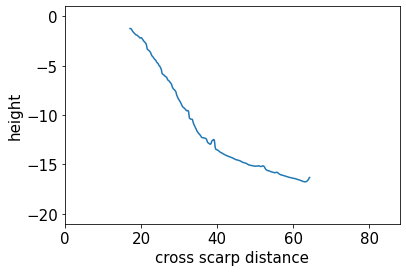

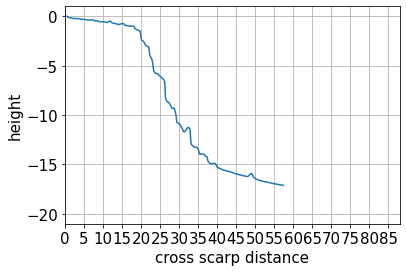

Input distance: 19


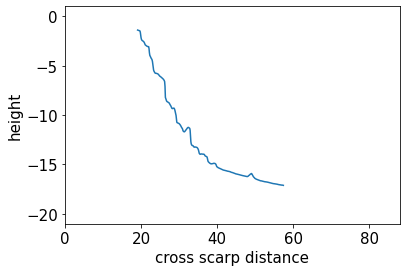

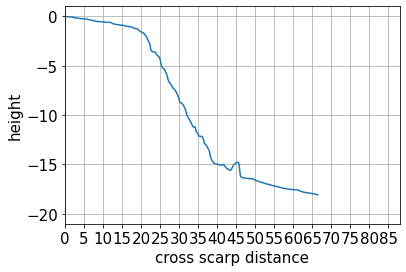

Input distance: 20


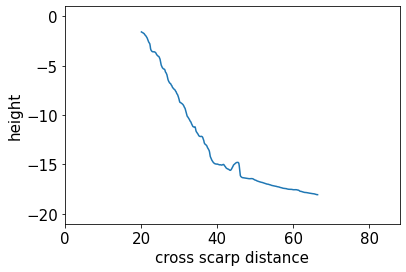

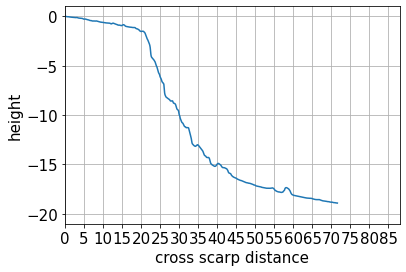

Input distance: 21


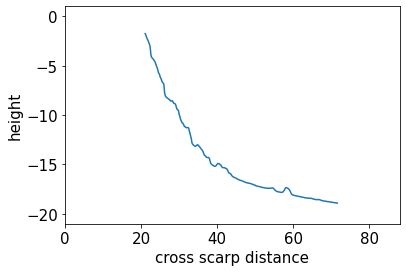

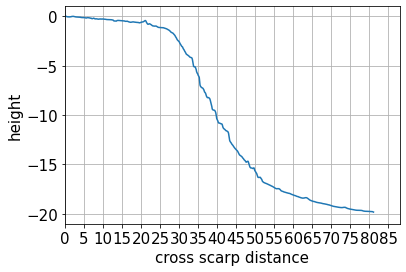

Input distance: 27.5


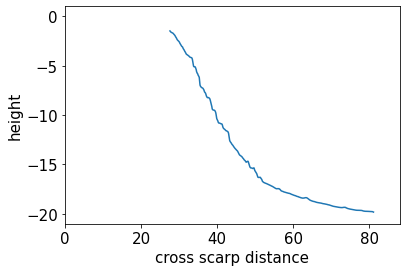

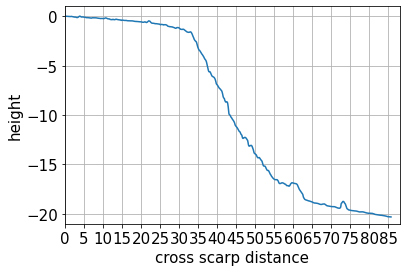

Input distance: 33


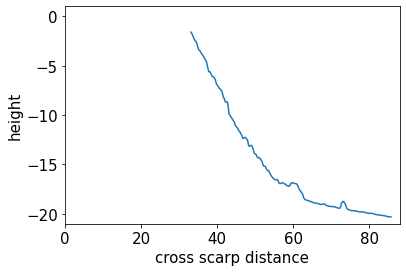

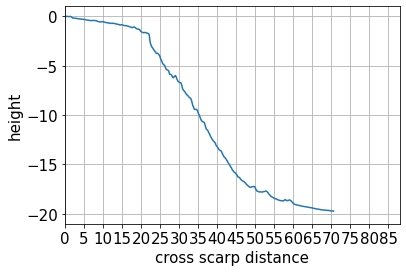

Input distance: 22


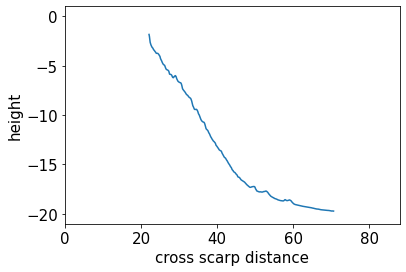

In [125]:
cropped_profile_ndarray = []
for i in range(16):
  cropped_profile = crop_profile(converted_profile_ndarray[i])
  cropped_profile_ndarray.append(cropped_profile)

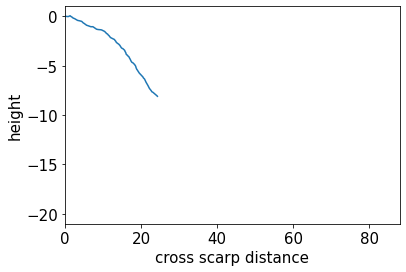

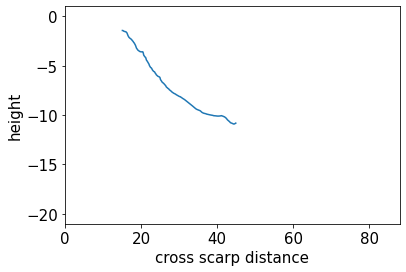

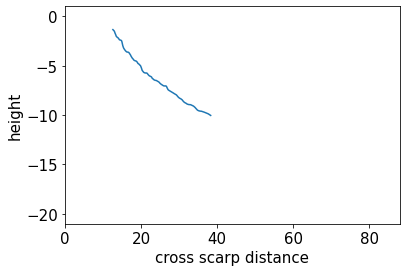

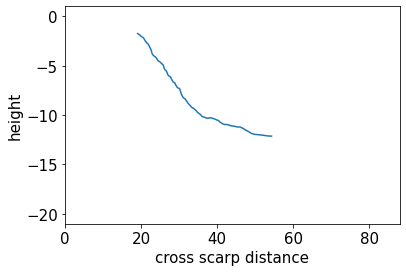

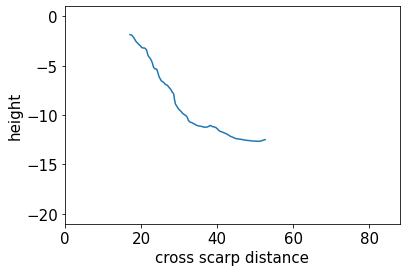

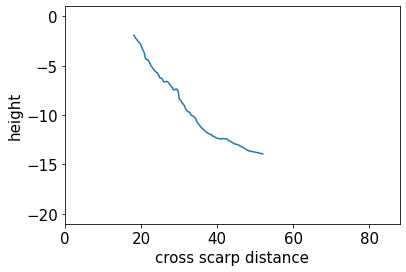

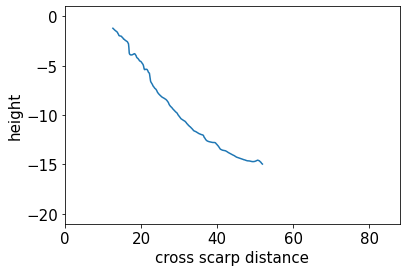

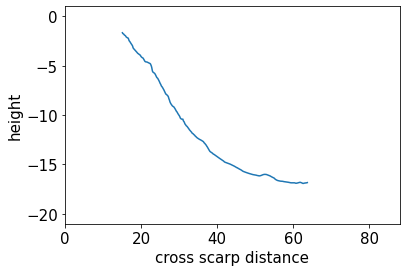

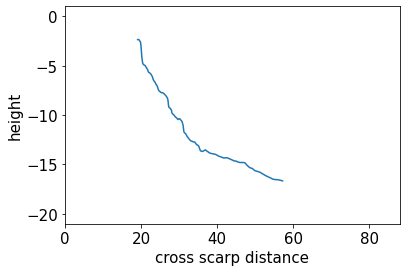

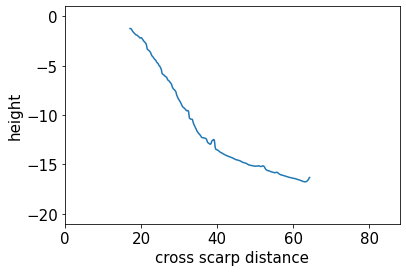

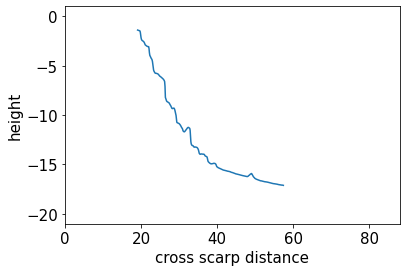

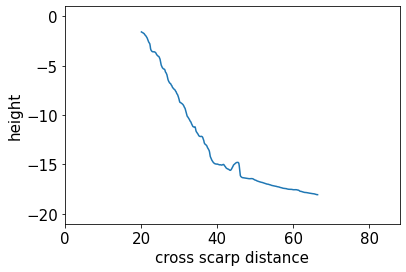

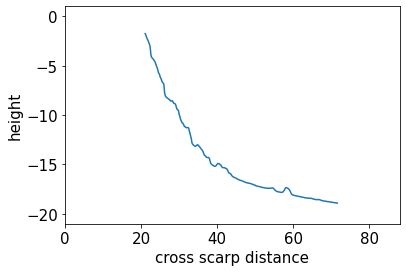

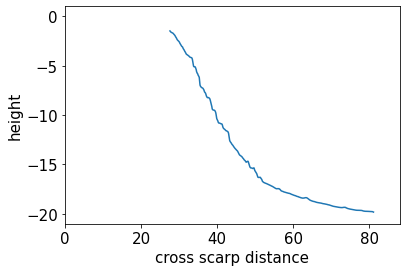

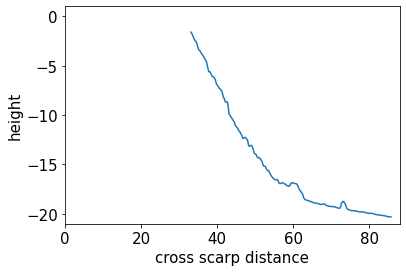

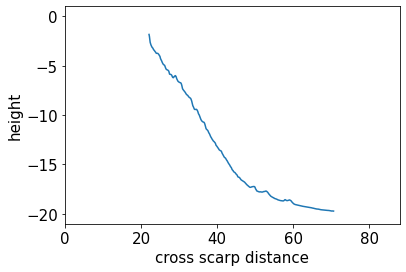

In [126]:
for i in range(16):
  display_profile(cropped_profile_ndarray[i])

In [167]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

#print line_intersection((A, B), (C, D))


def dist_hist(profile_ndarray):
  start_pt = profile_ndarray[0, :]
  end_pt = profile_ndarray[-1, :]
  v = start_pt - end_pt
  normalized_v = v/np.linalg.norm(v)
  normal_v = np.asarray((normalized_v[1], normalized_v[0]))
  dist = []
  for pt in profile_ndarray:
    pt1 = pt + normal_v*10
    pt2 = pt - normal_v*10
    ins_pt = line_intersection((pt1, pt2), (start_pt, end_pt))
    if pt[1] - ins_pt[1] > 0:
      d = np.linalg.norm(pt - ins_pt)
    else:
      d = -np.linalg.norm(pt - ins_pt)
    dist.append(d)
  plt.plot(profile_ndarray[:, 0], dist)
  plt.ylim(-10, 3)
  plt.show()
  abs_dist = np.absolute(dist)
  i = np.argmax(abs_dist)
  return dist[i]


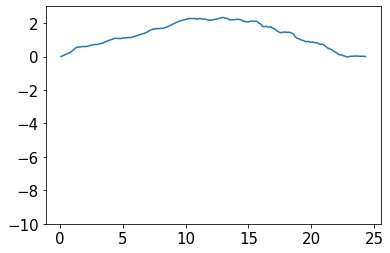

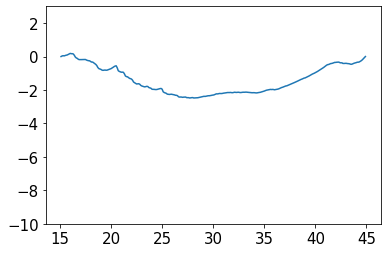

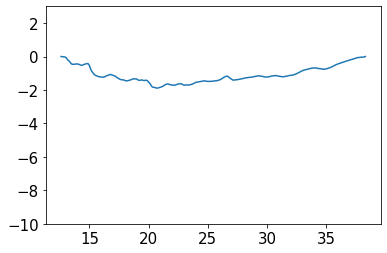

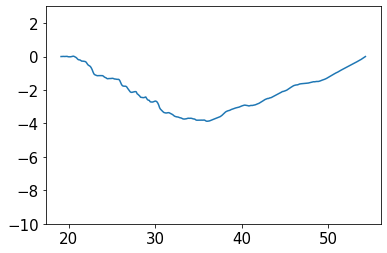

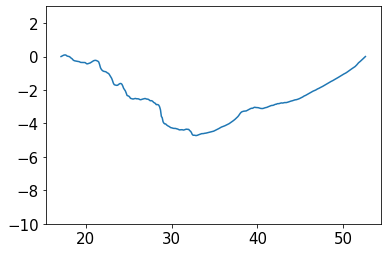

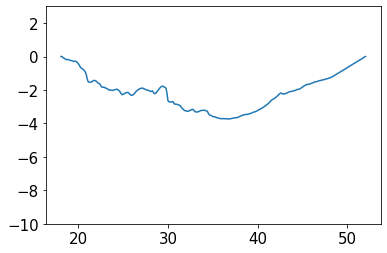

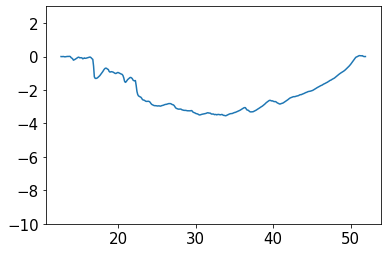

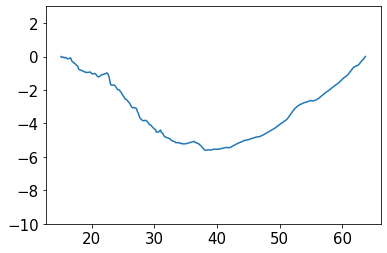

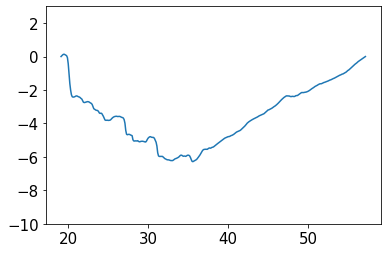

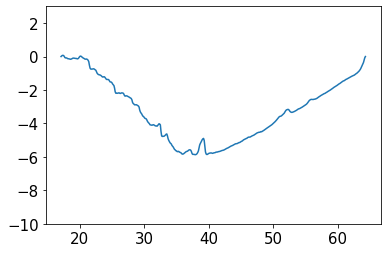

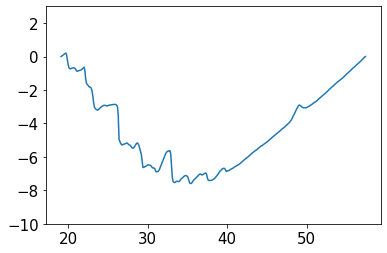

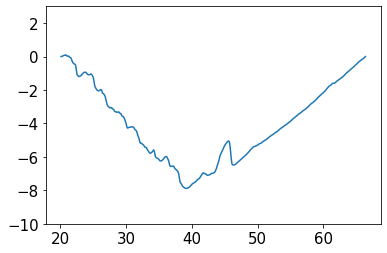

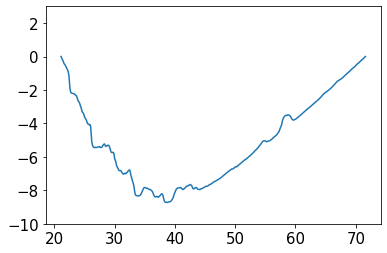

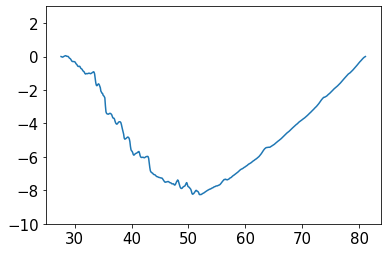

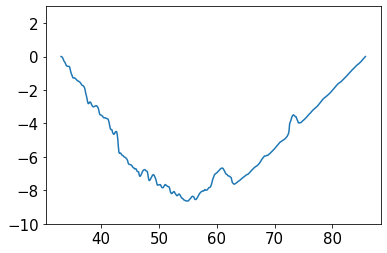

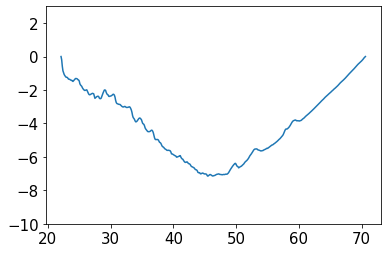

In [168]:
convexity_idx = []
for i in range(16):
  convexity_idx.append(dist_hist(cropped_profile_ndarray[i]))

In [169]:
convexity_idx

[2.338043135417305,
 -2.4784199822770714,
 -1.8914718315027463,
 -3.867920081027766,
 -4.722851383920697,
 -3.731701195533626,
 -3.5384450256614137,
 -5.606399793667494,
 -6.285596367637801,
 -5.867114601093982,
 -7.589835238206746,
 -7.8804507832004855,
 -8.727985168965166,
 -8.25565297559375,
 -8.640998516705766,
 -7.150122562061378]

In [170]:
lat_height_size_var = np.load('profile_data/lat_height_size_var.npy')

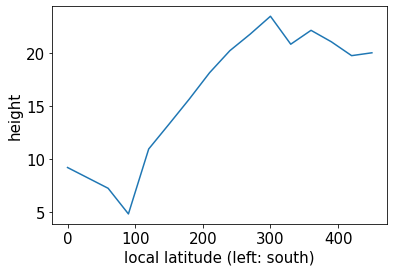

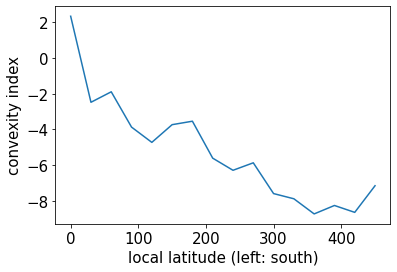

The correlation between height and convexity index is  -0.8000166662789281
1.985e-04
R^2:  0.6400266663240498


In [175]:
plt.plot(lat_height_size_var[:,0]-lat_height_size_var[:,0][0], lat_height_size_var[:,1])
plt.xlabel('local latitude (left: south)')
plt.ylabel('height')
plt.show()

plt.plot(lat_height_size_var[:,0]-lat_height_size_var[:,0][0], convexity_idx)
plt.xlabel('local latitude (left: south)')
plt.ylabel('convexity index')
plt.show()

cor, p = pearsonr(lat_height_size_var[:,1], convexity_idx)
print("The correlation between height and convexity index is ", cor)
print("{:.3e}".format(p))
print("R^2: ", cor**2)

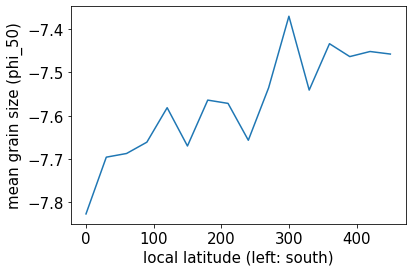

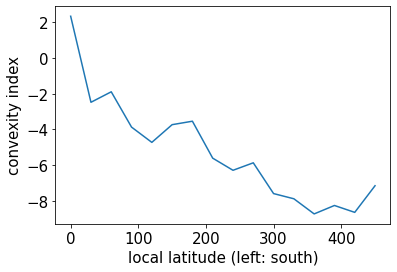

The correlation between mean grain size and convexity index is  -0.8926946835312408
p-value: 3.293e-06
R^2:  0.7969037980049422


In [177]:
plt.plot(lat_height_size_var[:,0]-lat_height_size_var[:,0][0], lat_height_size_var[:,2])
plt.xlabel('local latitude (left: south)')
plt.ylabel('mean grain size (phi_50)')
plt.show()

plt.plot(lat_height_size_var[:,0]-lat_height_size_var[:,0][0], convexity_idx)
plt.xlabel('local latitude (left: south)')
plt.ylabel('convexity index')
plt.show()

cor, p = pearsonr(lat_height_size_var[:,2], convexity_idx)
print("The correlation between mean grain size and convexity index is ", cor)
print("p-value: {:.3e}".format(p))
print("R^2: ", cor**2)

In [179]:
lat_height_largesize = np.load('profile_data/lat_height_largesize.npy')

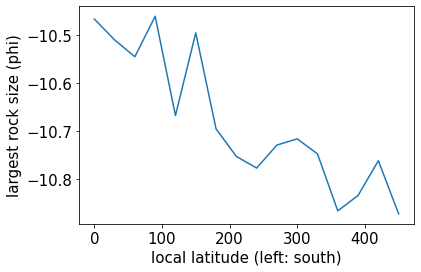

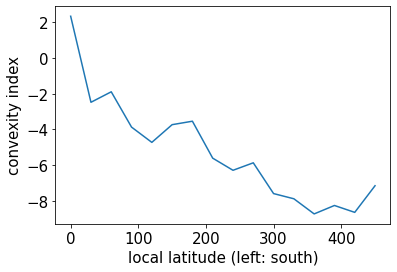

The correlation between largest rock size and convexity index is  0.8317912841093207
p-value: 6.468e-05
R^2:  0.6918767403202326


In [180]:
plt.plot(lat_height_largesize[:,0]-lat_height_largesize[:,0][0], lat_height_largesize[:,2])
plt.xlabel('local latitude (left: south)')
plt.ylabel('largest rock size (phi)')
plt.show()

plt.plot(lat_height_largesize[:,0]-lat_height_largesize[:,0][0], convexity_idx)
plt.xlabel('local latitude (left: south)')
plt.ylabel('convexity index')
plt.show()

cor, p = pearsonr(lat_height_largesize[:,2], convexity_idx)
print("The correlation between largest rock size and convexity index is ", cor)
print("p-value: {:.3e}".format(p))
print("R^2: ", cor**2)

## create shapefile

In [ ]:
# open a tif raster and read attributes 
c3 = rioxarray.open_rasterio("C3.tif")

In [ ]:
# attributes
print(c3.rio.crs)
print(c3.rio.nodata)
print(c3.rio.bounds())
print(c3.rio.width)
print(c3.rio.height)
print(c3.rio.resolution())

EPSG:32611
None
(372333.78378156334, 4145784.9609071277, 372544.16285686305, 4146294.8455599267)
10589
25664
(0.019867699999973145, -0.019867699999960856)


In [ ]:
epsg = c3.rio.crs.to_epsg()
crs = CRS(epsg)
crs

<Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 120°W and 114°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Alberta; British Columbia (BC); Northwest Territories (NWT); Nunavut. Mexico. United States (USA).
- bounds: (-120.0, 0.0, -114.0, 84.0)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich